In [1]:
import mo_descriptor as md
import nn_frame as nn
import numpy as np
import subprocess
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2022-11-01 18:12:11.311912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 18:12:11.312034: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [2]:
'''
prepare data_set
1. make mo_pair descriptor
'''
# x_shift = np.arange(0, 4.1, 0.1)
# y_shift = np.arange(0, 4.1, 0.1)
# z_shift = np.zeros(x_shift.shape)
# # the original mo, e.g. homo
# homo = md.MO_descriptor('data/homo-s0.cube').make()
# lumo = md.MO_descriptor('data/lumo-s0.cube').make()

# # for the original pair of one mo and itself
# homo_pair = md.MO_pair_descriptor(homo, homo).make()
# lumo_pair = md.MO_pair_descriptor(lumo, lumo).make()

# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)

# homo_ = np.zeros(homo.shape)
# lumo_ = np.zeros(lumo.shape)

# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_[:,0] = np.add(homo[:,0],0)
#         homo_[:,1] = np.add(homo[:,1],i)
#         homo_[:,2] = np.add(homo[:,2],j)
#         homo_[:,3] = np.add(homo[:,3],3.5)
        
#         homo_pair_ = md.MO_pair_descriptor(homo, homo_).make()
#         homo_pairs[idx] = homo_pair_
        
#         lumo_[:,0] = np.add(lumo[:,0],0)
#         lumo_[:,1] = np.add(lumo[:,1],i)
#         lumo_[:,2] = np.add(lumo[:,2],j)
#         lumo_[:,3] = np.add(lumo[:,3],3.5)
        
#         lumo_pair_ = md.MO_pair_descriptor(lumo, lumo_).make()
#         lumo_pairs[idx] = lumo_pair_
        
# def dir_mat(mat):
#     mat_shape = mat.shape
#     mat_ = mat.flatten()
#     for ii, i in enumerate(mat_):
#         if i > 1e-6:
#             mat_[ii] = 1
#         elif (i < 1e-6) and (i > -1e-6):
#             mat_[ii] = -1
#         elif i < -1e-6:
#             mat_[ii] = -1
#     return mat_.reshape(mat_shape)

# direct = dir_mat(homo_pair)

# # for the shifted pair
# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)
# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_pairs[idx][0] = homo_pair[0]
#         homo_pairs[idx][1] = np.add(homo_pair[1],i*direct[1])
#         homo_pairs[idx][2] = np.add(homo_pair[2],j*direct[2])
#         homo_pairs[idx][3] = homo_pair[3]
#         lumo_pairs[idx][0] = lumo_pair[0]
#         lumo_pairs[idx][1] = np.add(lumo_pair[1],i)
#         lumo_pairs[idx][2] = np.add(lumo_pair[2],j)
#         lumo_pairs[idx][3] = lumo_pair[3]
# np.save('homo_homo_pair.npy', homo_pairs)
# np.save('lumo_lumo_pair.npy', lumo_pairs)
homo_pairs = np.load('homo_homo_pair.npy')
lumo_pairs = np.load('lumo_lumo_pair.npy')

In [3]:
'''
2. read coupling
'''
raw_data = np.loadtxt('../ML_Coupling/results.csv', delimiter=',',comments='#')
# c_homo = np.add(raw_data[:,2], raw_data[:,3]) * 1/2
# c_lumo = np.add(raw_data[:,4], raw_data[:,5]) * 1/2
c_homo = abs(raw_data[:,3])
c_lumo = abs(raw_data[:,4])

In [4]:
# x1 = homo_pairs[:,0,:,:]
# x2 = homo_pairs[:,1,:,:]
# x3 = homo_pairs[:,2,:,:]
# x4 = homo_pairs[:,3,:,:]
# x = np.einsum('aij,aij,aij,aij->aij', x1, x2, x3, x4)

train_homo_pairs = homo_pairs
train_lumo_pairs = lumo_pairs

train_c_homo = -np.log(c_homo)
train_c_lumo = -np.log(c_lumo)

test_homo_pairs = homo_pairs[1200:]
test_lumo_pairs = lumo_pairs[1200:]

test_c_homo = c_homo[1200:].reshape((len(c_homo[1200:]),1))
test_c_lumo = c_lumo[1200:]

In [153]:
import copy
train_homo = copy.deepcopy(train_homo_pairs)
train_chomo = copy.deepcopy(train_c_homo)
print(len(train_chomo))
index = np.random.choice(1681,size=481, replace=False)
train_homo_ = np.delete(train_homo,index,0)
train_chomo_ = np.delete(train_chomo,index,0)
print(len(train_homo_))

1681
1200


In [154]:
iall = np.arange(1681)
idiff = np.setdiff1d(iall,index)
test_homo = np.delete(copy.deepcopy(train_homo_pairs),idiff,0)
test_chomo = np.delete(copy.deepcopy(train_chomo),idiff,0)

In [167]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

class GPR():
    def __init__(self, json_path=None, setting_dict=None):
        setting_ = {'alpha':1, 'kernel':'RBF', 'optimizer':'fmin_l_bfgs_b', 'length_scale':1.0, 'length_scale_bounds':(1e-2, 1e2)}  # default setting   
        if json_path is not None:
            setting = json.load(json_path)
        elif (json_path is None) and (setting_dict is not None):
            setting = setting_dict
        else:
            print('No setting is specified, default setting will be applied.')
            setting = setting_
        self.setting = setting

        if self.setting['kernel'] == 'RBF':
            self.kernel = RBF(length_scale=self.setting['length_scale'], length_scale_bounds=self.setting['length_scale_bounds'])
        
        self.alpha = self.setting['alpha']

    def train(self, X, Y):
        self.model = GaussianProcessRegressor(kernel=self.kernel, alpha=self.alpha)
        self.model.fit(X, Y)

    def predict(self, X):
        x_pred, std_pred = self.model.predict(X, return_std=True)
        return x_pred, std_pred
    
gpr = GPR(setting_dict={'alpha':0.01, 'kernel':'RBF', 'optimizer':'fmin_l_bfgs_b', 'length_scale':0.1, 'length_scale_bounds':(1e-2, 1e1)})
dshape = train_homo_.shape
new_train = train_homo_.reshape((dshape[0],dshape[1]*dshape[2]*dshape[3]))
print(new_train.shape)
gpr.train(new_train, train_chomo_)
pred, std = gpr.predict(test_homo.reshape((481,2*8*8)))
print(np.mean(np.multiply(pred-test_chomo, np.power(test_chomo,-1))*100))
print(mse(test_chomo,pred))

(1200, 128)
-0.18881879179049585
0.05185095228258292


481


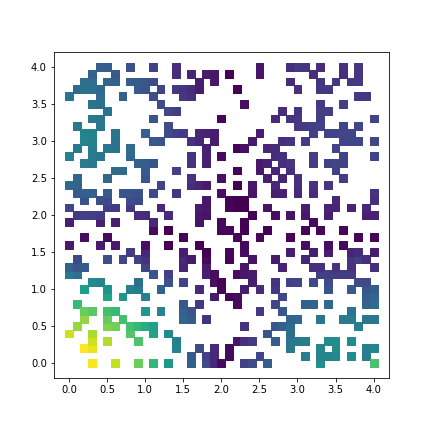

In [165]:
C = []
for i in x:
    for j in y:
        C_ = (i,j)
        C.append(C_)
C = np.array(C)
C_ = copy.deepcopy(C)
C = np.delete(C,index,0)
C__ = np.delete(C_,idiff,0)
print(len(C__))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(C__[:, 0], C__[:, 1], c=np.exp(-pred),s=62, marker=',')

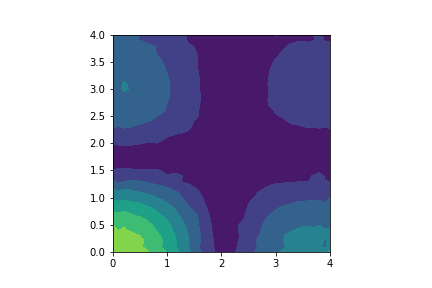

In [166]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

# error = np.mean(np.multiply(NN.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),))-train_c_homo, np.power(train_c_homo,-1))*100)
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
# Z = NN.model(train_homo_pairs, training=False).numpy().reshape((41,41)).T
pred, std = gpr.predict(train_homo_pairs.reshape((1681,2*8*8)))
Z = pred.reshape((41,41)).T
Z1 = c_homo.reshape((41,41)).T

fix, ax = plt.subplots()
ax.contourf(x,y, np.exp(-Z))
# ax.set_title('Error: %5.3f%%'%error)
ax.set_aspect('equal')

# plt.savefig('homo_pred.png')

In [33]:
setting = {'activation':'tanh', 'nn_shape':(256,256,256), 'batch_size':len(train_chomo_), 'training_steps':200000,\
'learning_rate': 0.00001, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':100, 'drop_rate':0, 'save_path':'./save',\
'seed':None, 'debug_traj':False}
NN = nn.NN(setting_dict=setting)
NN.train(train_homo_,train_chomo_)

loss:  38.2351761
training step:     0
loss:  36.3010941
training step:   100
loss:  35.9786453
training step:   200
loss:  35.6986084
training step:   300
loss:  35.4178696
training step:   400
loss:  35.1384583
training step:   500
loss:  34.8579559
training step:   600
loss:  34.5712624
training step:   700
loss:  34.2758751
training step:   800
loss:  33.9719543
training step:   900
loss:  33.6591454
training step:  1000
loss:  33.3372078
training step:  1100
loss:  33.0065498
training step:  1200
loss:  32.6675453
training step:  1300
loss:  32.3210831
training step:  1400
loss:  31.9673042
training step:  1500
loss:  31.6065369
training step:  1600
loss:  31.2391834
training step:  1700
loss:  30.865593
training step:  1800
loss:  30.4862118
training step:  1900
loss:  30.1014347
training step:  2000
loss:  29.7116241
training step:  2100
loss:  29.3172531
training step:  2200
loss:  28.9180794
training step:  2300
loss:  28.5150871
training step:  2400
loss:  28.1082821
training

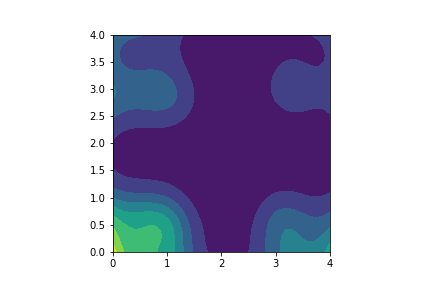

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

error = np.mean(np.multiply(NN.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),))-train_c_homo, np.power(train_c_homo,-1))*100)
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
Z = NN.model(train_homo_pairs, training=False).numpy().reshape((41,41)).T
Z1 = c_homo.reshape((41,41)).T

fix, ax = plt.subplots()
ax.contourf(x,y, np.exp(-Z))
ax.set_title('Error: %5.3f%%'%error)
ax.set_aspect('equal')
# plt.savefig('homo_pred.png')

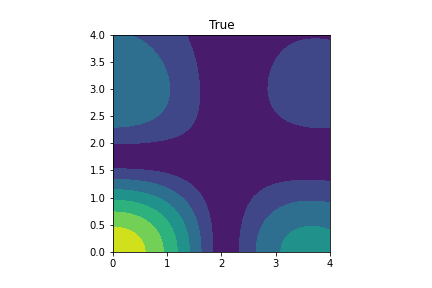

In [36]:
fix, ax = plt.subplots()
ax.contourf(x,y, Z1)
ax.set_title('True')
ax.set_aspect('equal')
# plt.savefig('homo_true.png')

481


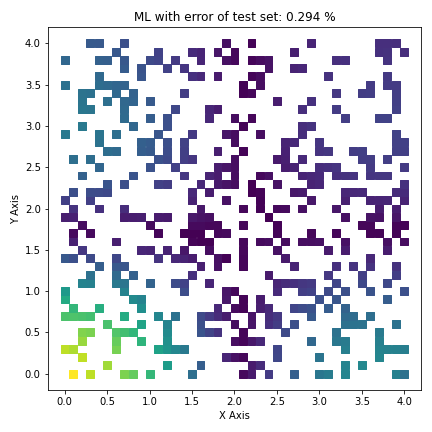

In [37]:
C = []
for i in x:
    for j in y:
        C_ = (i,j)
        C.append(C_)
C = np.array(C)
C_ = copy.deepcopy(C)
C = np.delete(C,index,0)
C__ = np.delete(C_,idiff,0)
print(len(C__))

Z = NN.model(test_homo, training=False).numpy()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(C__[:, 0], C__[:, 1], c=np.exp(-Z),s=62, marker=',')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')

error = np.mean(np.multiply(NN.model(test_homo, training=False).numpy().reshape((len(test_homo),))-test_chomo, np.power(test_chomo,-1))*100)
plt.title('ML with error of test set: %5.3f %%'%error)
plt.tight_layout()
plt.show()

# plt.savefig('test.jpg')

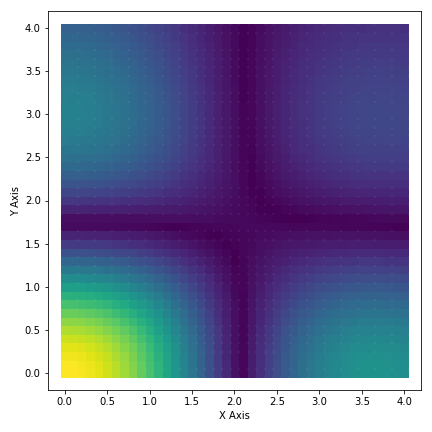

In [38]:
Z1 = train_chomo
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(C_[:, 0], C_[:, 1], c=np.exp(-Z1),s=62, marker=',')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')

# plt.title('HOMO of Naphthalene')
plt.tight_layout()
plt.show()
# plt.savefig('test.jpg')

In [39]:
error1 = np.mean(np.multiply(NN.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),))-train_c_homo, np.power(train_c_homo,-1))*100)
error2 = np.mean(np.multiply(NN.model(train_homo_, training=False).numpy().reshape((len(train_homo_),))-train_chomo_, np.power(train_chomo_,-1))*100)
error3 = np.mean(np.multiply(NN.model(test_homo, training=False).numpy().reshape((len(test_homo),))-test_chomo, np.power(test_chomo,-1))*100)
print('Error of full data set: %5.3f %% \nError of training set with %d samples: %5.3f %% \nError of testing set with %d samples: %5.3f %% '%(error1,len(train_homo_),error2,len(test_homo),error3))

Error of full data set: 0.085 % 
Error of training set with 1200 samples: 0.001 % 
Error of testing set with 481 samples: 0.294 % 


In [ ]:
NN.model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 concatenate (Concatenate)   multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 1024      
 ormalization)                                                   
                                                               